In [2]:
!pip install geopy

     |████████████████████████████████| 102kB 6.5MB/s ta 0:00:011


In [27]:
import numpy as np # library to handle data in a vectorized manner
import io
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library


## First, let's load the data and transform it to dataframe.

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

## Create a map of New York with neighborhoods superimposed on top

In [7]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [8]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Explore Neighborhoods in NY

In [29]:
CLIENT_ID = 'OTHZPWYQWQUHS0FEOMPIH5JJPVKRVVFN54NRPIDSP1SOYZWM' # your Foursquare ID
CLIENT_SECRET = 'JTBUA3WMRG4KEIDFGVYZK13S0Y03VT1R22EMDNX12N1TELIZ' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

In [19]:
LIMIT = 100
radius = 500

In [206]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [30]:
def getNearbyVenues(names, borough, latitudes, longitudes):
    
    venues_list=[]
    for name, bor, lat, lng in zip(names, borough, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            bor,
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood','borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
neighborhoods_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                       borough = neighborhoods['Borough'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [32]:
print(neighborhoods_venues.shape)
neighborhoods_venues.head()

(10243, 8)


,Neighborhood,borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,Bronx,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,Bronx,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,Bronx,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,Bronx,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,Wakefield,Bronx,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant


In [33]:
neighborhoods_venues.groupby('Neighborhood').count()

,borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Allerton,32,32,32,32,32,32,32
Annadale,9,9,9,9,9,9,9
Arden Heights,4,4,4,4,4,4,4
Arlington,6,6,6,6,6,6,6
Arrochar,18,18,18,18,18,18,18
Arverne,18,18,18,18,18,18,18
Astoria,100,100,100,100,100,100,100
Astoria Heights,13,13,13,13,13,13,13
Auburndale,19,19,19,19,19,19,19


In [34]:
print('There are {} uniques categories.'.format(len(neighborhoods_venues['Venue Category'].unique())))

There are 430 uniques categories.


Analyze each neighborhood

In [35]:
# one hot encoding
neighborhoods_onehot = pd.get_dummies(neighborhoods_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighborhoods_onehot['Neighborhood'] = neighborhoods_venues['Neighborhood'] 
neighborhoods_onehot['Borough']=neighborhoods_venues['borough']
# move neighborhood column to the first column
fixed_columns = [neighborhoods_onehot.columns[-1]] + list(neighborhoods_onehot.columns[:-1])
neighborhoods_onehot = neighborhoods_onehot[fixed_columns]

neighborhoods_onehot.head()

,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Sh

In [36]:
neighborhoods_grouped = neighborhoods_onehot.groupby(['Neighborhood','Borough']).mean().reset_index()
print(neighborhoods_grouped.columns)

Index(['Neighborhood', 'Borough', 'Accessories Store', 'Adult Boutique',
       'Afghan Restaurant', 'African Restaurant', 'Airport Terminal',
       'American Restaurant', 'Antique Shop', 'Arcade',
       ...
       'Warehouse Store', 'Waste Facility', 'Waterfront', 'Weight Loss Center',
       'Whisky Bar', 'Wine Bar', 'Wine Shop', 'Wings Joint', 'Women's Store',
       'Yoga Studio'],
      dtype='object', length=431)


## Relationship between neighborhood and Chinese Restaurant

In [37]:
CR_grouped = neighborhoods_grouped[['Neighborhood','Borough','Chinese Restaurant']]
CR_grouped.head()

,Neighborhood,Borough,Chinese Restaurant
0,Allerton,Bronx,0.09375
1,Annadale,Staten Island,0.00000
2,Arden Heights,Staten Island,0.00000
3,Arlington,Staten Island,0.00000
4,Arrochar,Staten Island,0.00000


In [38]:
CR_grouped.sort_values('Chinese Restaurant',ascending = False)

,Neighborhood,Borough,Chinese Restaurant
114,Glendale,Queens,0.200000
252,Soundview,Bronx,0.176471
20,Bellaire,Queens,0.166667
19,Beechhurst,Queens,0.153846
43,Canarsie,Brooklyn,0.142857
86,Edenwald,Bronx,0.142857
109,Fresh Meadows,Queens,0.133333
200,Oakland Gardens,Queens,0.125000
223,Queensboro Hill,Queens,0.120000
287,Weeksville,Brooklyn,0.117647


In [39]:
CR_grouped['Borough'].unique()

array(['Bronx', 'Staten Island', 'Queens', 'Brooklyn', 'Manhattan'],
      dtype=object)

### violin plot

In [44]:
import matplotlib.pyplot as plt

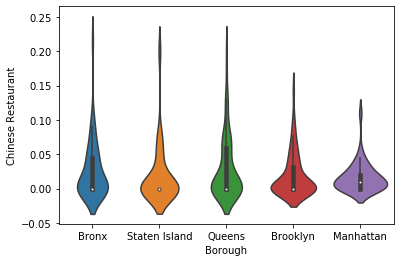

In [108]:
import seaborn as sns
ax = sns.violinplot(x="Borough", y="Chinese Restaurant", data=CR_grouped)

In [40]:
CR = CR_grouped.sort_values('Chinese Restaurant',ascending = False)

In [41]:
CR = CR[:20]

### Histogram plot

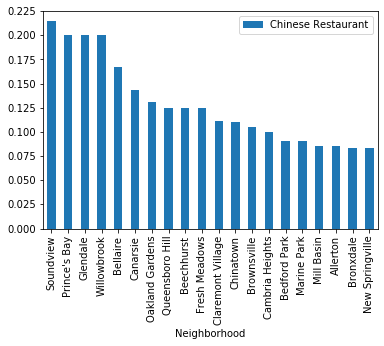

In [121]:
CR.plot(kind='bar',x='Neighborhood',y='Chinese Restaurant')

### Stacked histogram plot

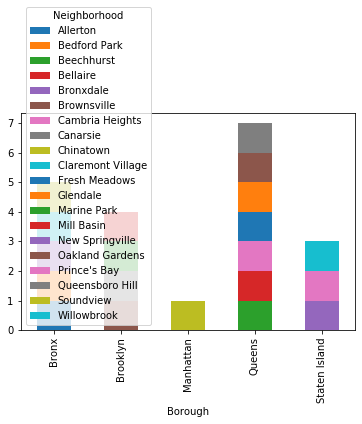

In [120]:
CR.groupby(['Borough','Neighborhood']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

## Predictive Modelling

### fing best k in Cluster

In [45]:
from sklearn.cluster import KMeans

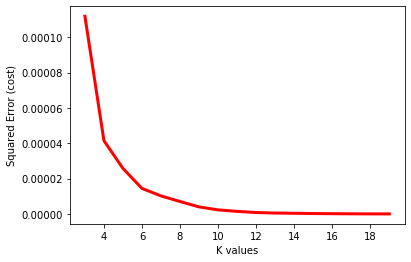

In [46]:
CR_grouped1 = CR_grouped[CR_grouped['Borough'] == 'Bronx'].reset_index(drop=True)
NY_part_clustering = CR_grouped1.drop(['Borough','Neighborhood'],1)
error_cost = []
for i in range(3,20):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(NY_part_clustering)
    except ValueError:
        print("error on line",i)
    error_cost.append(KM.inertia_/100)
plt.plot(range(3,20),error_cost,color='r',linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (cost)')
plt.grid(color='white',linestyle ='-',linewidth=2)
plt.show()

In [47]:
kclusters=11
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(NY_part_clustering)

In [48]:
CR_grouped1.insert(0,'Cluster Labels',kmeans.labels_)
NY_merged = neighborhoods_venues
NY_merged =NY_merged.join(CR_grouped1.set_index('Neighborhood'),on='Neighborhood')
NY_merged.dropna(subset=["Cluster Labels"],axis=0,inplace=True)
NY_merged.reset_index(drop=True,inplace=True)
NY_merged['Cluster Labels'].astype(int)
NY_merged.head()

,Neighborhood,borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Borough,Chinese Restaurant
0,Wakefield,Bronx,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,1.0,Bronx,0.0
1,Wakefield,Bronx,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,1.0,Bronx,0.0
2,Wakefield,Bronx,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,1.0,Bronx,0.0
3,Wakefield,Bronx,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station,1.0,Bronx,0.0
4,Wakefield,Bronx,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant,1.0,Bronx,0.0


In [49]:
queens_ = NY_merged.sort_values('Chinese Restaurant',ascending = False)
queens_.iloc[:,8]=queens_.iloc[:,8].fillna(0).astype(int)
queens_map =queens_[:800]

In [50]:
queens_map.iloc[:,8].unique()

array([ 5,  2,  7,  6,  3,  8,  0, 10,  4,  9,  1])

### Folium map for the clusters of different neighborhoods

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
kclusters =11
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_map['Neighborhood Latitude'], queens_map['Neighborhood Longitude'], queens_map['Neighborhood'],queens_map['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Cluster

In [53]:
#1
NY_merged.loc[NY_merged['Cluster Labels'] == 10, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

,borough,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Borough,Chinese Restaurant
153,Bronx,40.875269,-73.879563,Pizza Place,10.0,Bronx,0.034483
154,Bronx,40.877033,-73.877331,Park,10.0,Bronx,0.034483
155,Bronx,40.874933,-73.879404,Coffee Shop,10.0,Bronx,0.034483
156,Bronx,40.880766,-73.877808,Pizza Place,10.0,Bronx,0.034483
157,Bronx,40.878234,-73.883164,Park,10.0,Bronx,0.034483
158,Bronx,40.880200,-73.883434,Mexican Restaurant,10.0,Bronx,0.034483
159,Bronx,40.881665,-73.879484,Deli / Bodega,10.0,Bronx,0.034483
160,Bronx,40.874727,-73.879660,Bank,10.0,Bronx,0.034483
161,Bronx,40.874499,-73.879515,Pharmacy,10.0,Bronx,0.034483
162,Bronx,40.881566,-73.879299,Restaurant,10.0,Bronx,0.034483


In [54]:
#2
NY_merged.loc[NY_merged['Cluster Labels'] == 0, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

,borough,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Borough,Chinese Restaurant
26,Bronx,40.885656,-73.829197,Caribbean Restaurant,0.0,Bronx,0.052632
27,Bronx,40.886332,-73.827616,Diner,0.0,Bronx,0.052632
28,Bronx,40.888628,-73.831260,Pizza Place,0.0,Bronx,0.052632
29,Bronx,40.889318,-73.831453,Seafood Restaurant,0.0,Bronx,0.052632
30,Bronx,40.885384,-73.828099,Donut Shop,0.0,Bronx,0.052632
31,Bronx,40.888235,-73.831282,Deli / Bodega,0.0,Bronx,0.052632
32,Bronx,40.888488,-73.831083,Caribbean Restaurant,0.0,Bronx,0.052632
33,Bronx,40.886020,-73.823207,Bowling Alley,0.0,Bronx,0.052632
34,Bronx,40.888249,-73.831661,Caribbean Restaurant,0.0,Bronx,0.052632
35,Bronx,40.887969,-73.831413,Diner,0.0,Bronx,0.052632
